In [122]:
import re
import pandas
import glob
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [123]:
def get_model_name(path):
    return re.sub('.csv', '', re.sub("^.*/", '', path))

In [124]:
columns = ["timestamp", "seed", "env", "levelid", "move_limit", "click_limit", "objectives", "moves_performed",
           "clicks_performed", "objectives_achieved", "reward"]
eval_files = glob.glob("logs/eval/*.csv")
eval_data = [{'name': get_model_name(f), 'dataframe': pandas.read_csv(f, header=0, names=columns, index_col=False)} for
             f in eval_files]

## Completion Rate (300+)

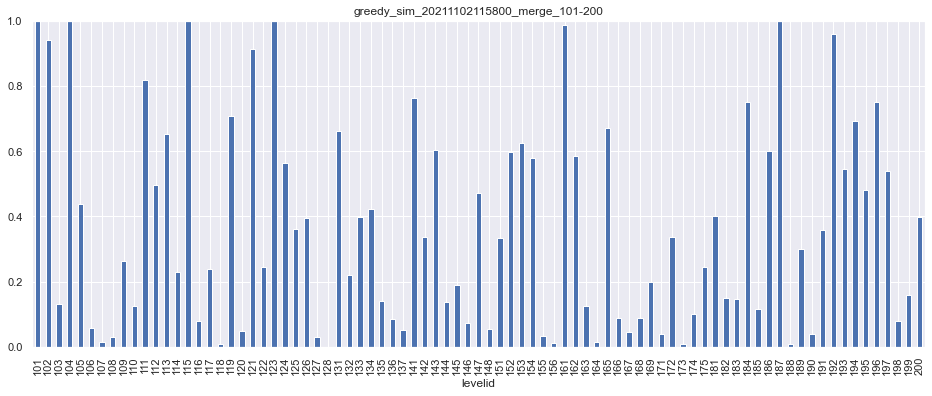

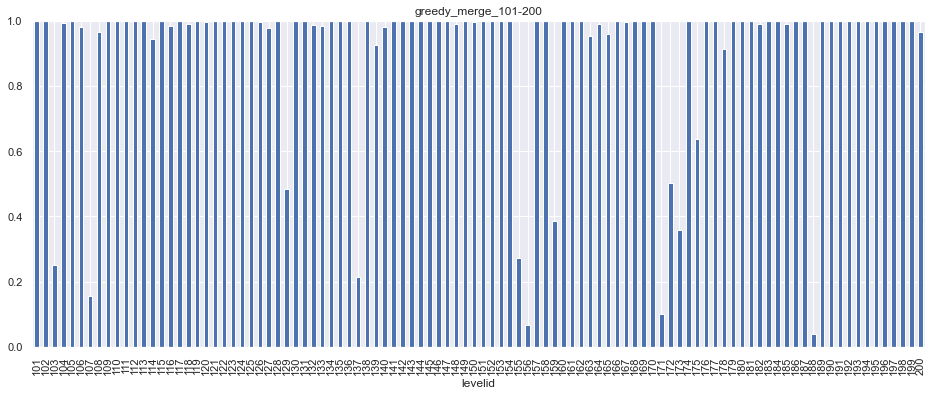

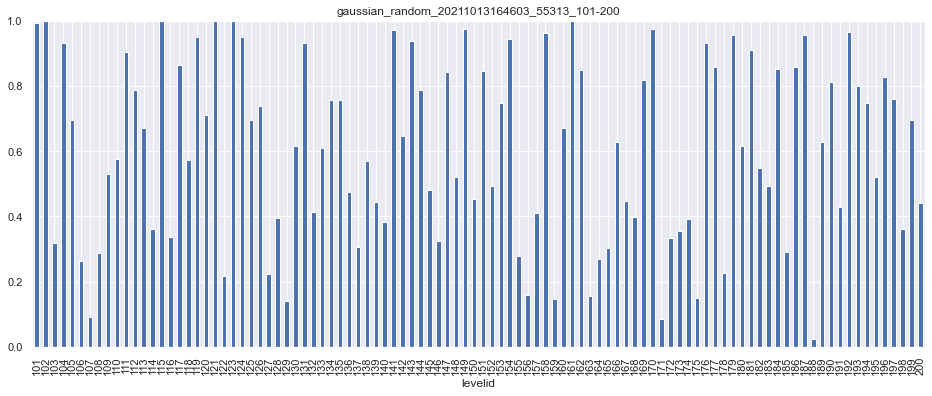

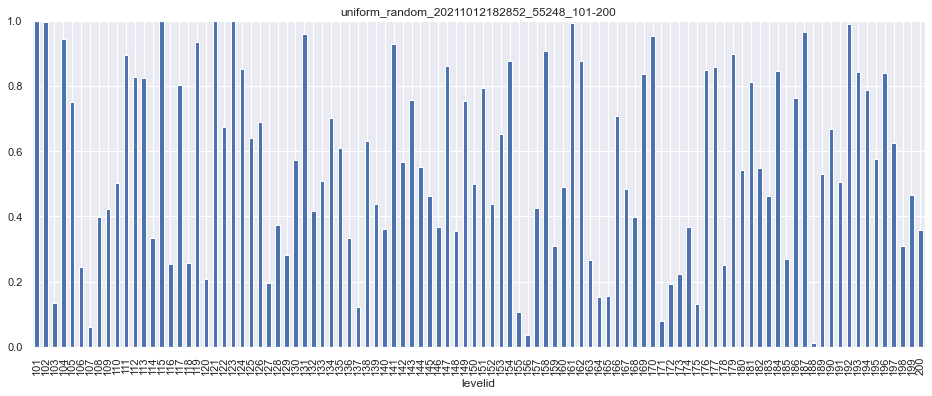

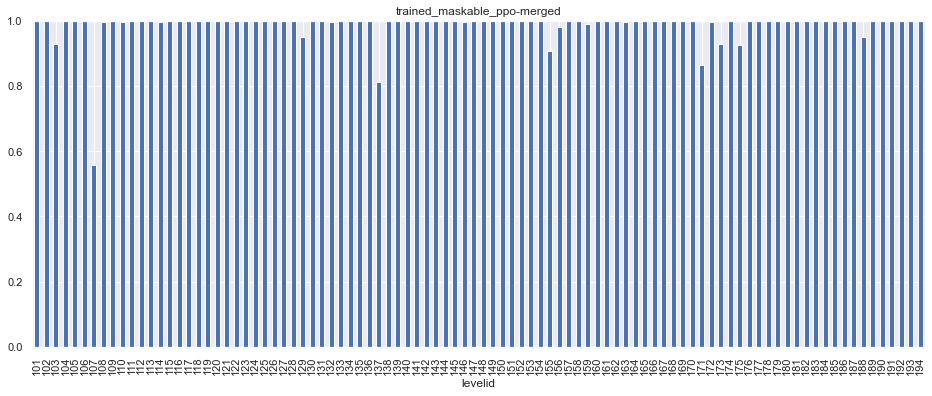

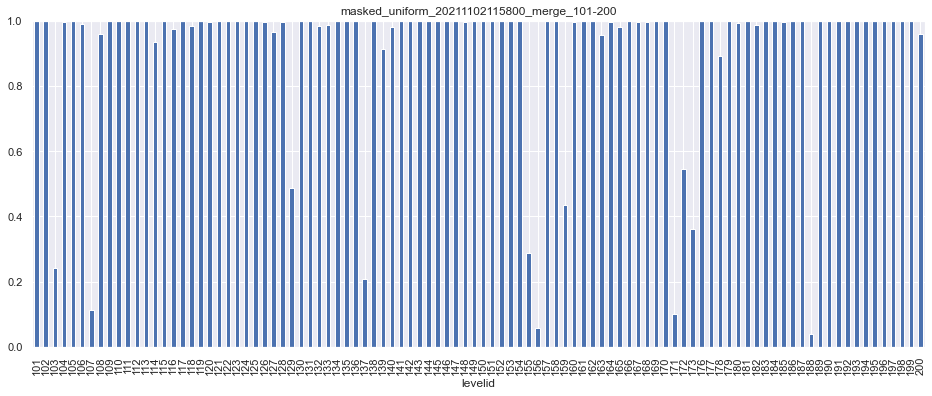

In [125]:
for ev in eval_data:
    ev['dataframe']['completed'] = ev['dataframe']['objectives'] == ev['dataframe']['objectives_achieved']

    ev['dataframe']['completed_limit'] = ev['dataframe']['completed']
    ev['dataframe']['completed_limit'] &= ev['dataframe']['moves_performed'] <= ev['dataframe']['move_limit']

    pass_rate = ev['dataframe'].groupby('levelid').aggregate('mean')['completed']
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])
    plt.ylim((0, 1))
    pass_rate.plot.bar()

## Completion Rate (Level Limit)

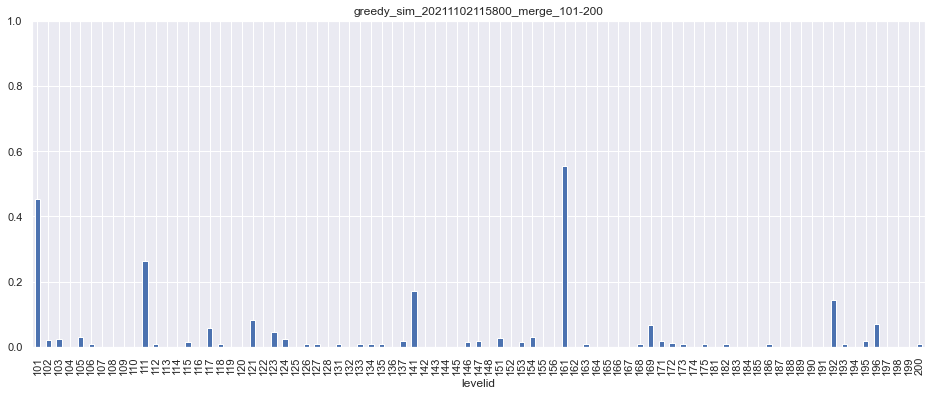

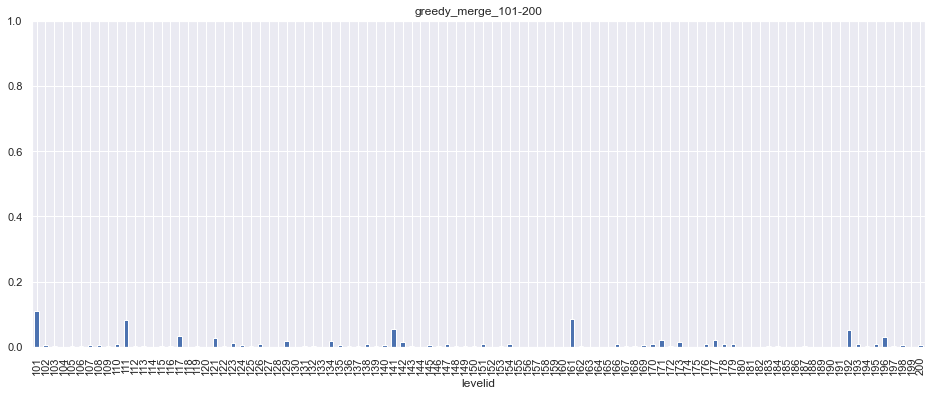

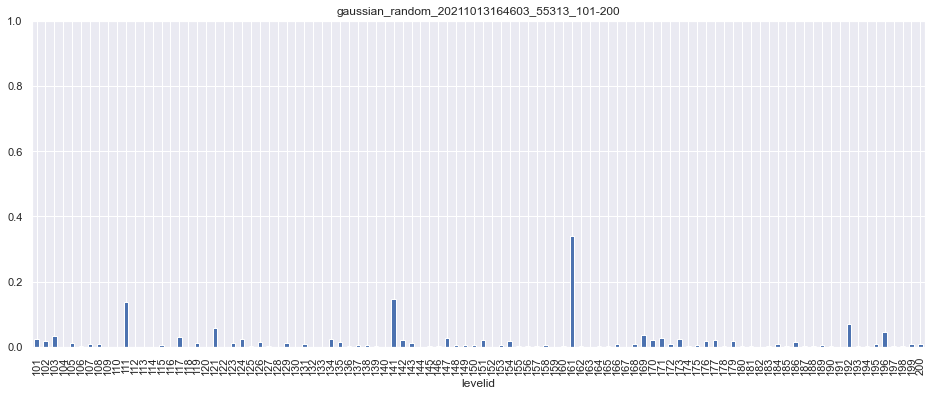

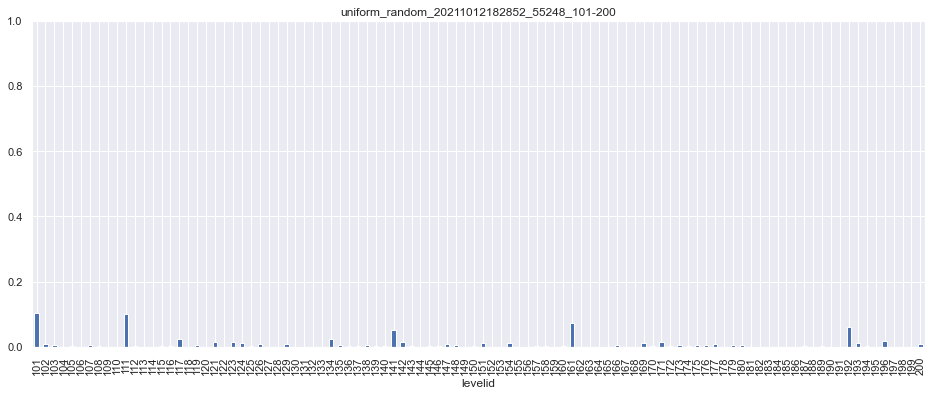

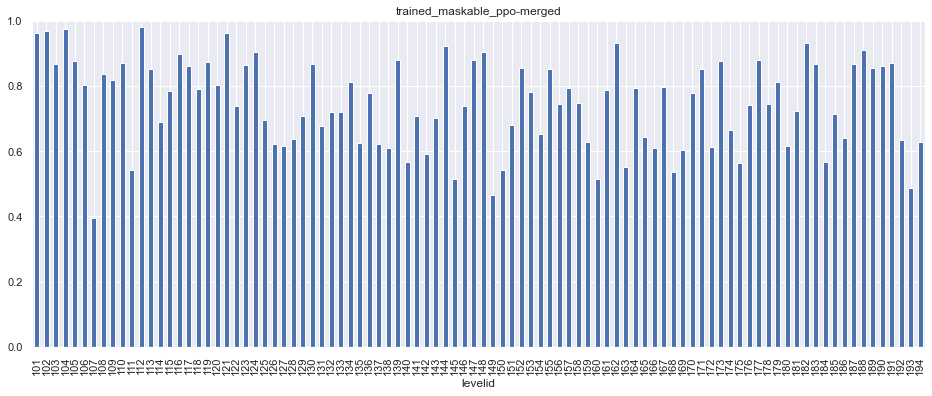

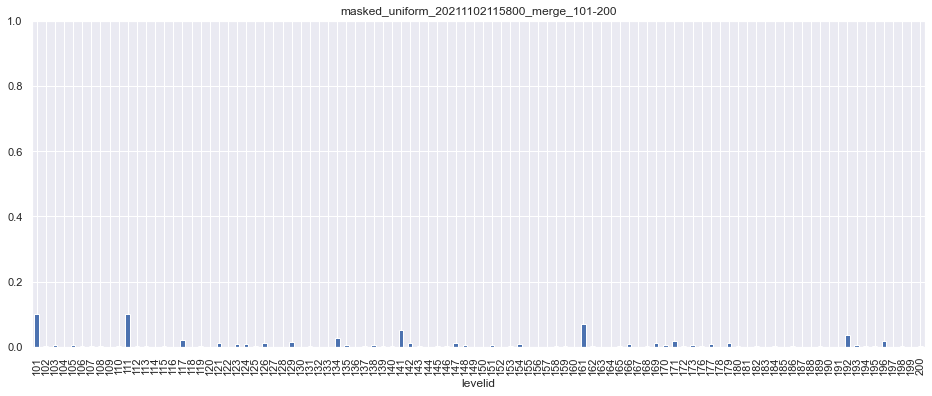

In [126]:
for ev in eval_data:
    pass_rate = ev['dataframe'].groupby('levelid').aggregate('mean')['completed_limit']
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])
    plt.ylim((0, 1))
    pass_rate.plot.bar()

## Median moves to complete a level (normalised by the level move limit)

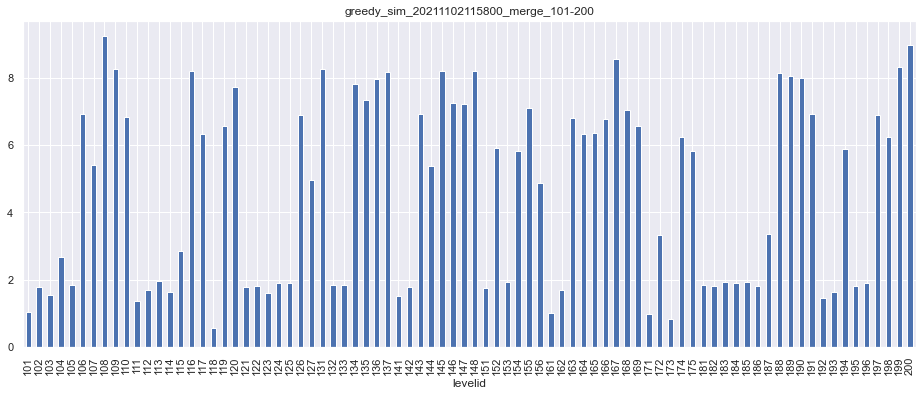

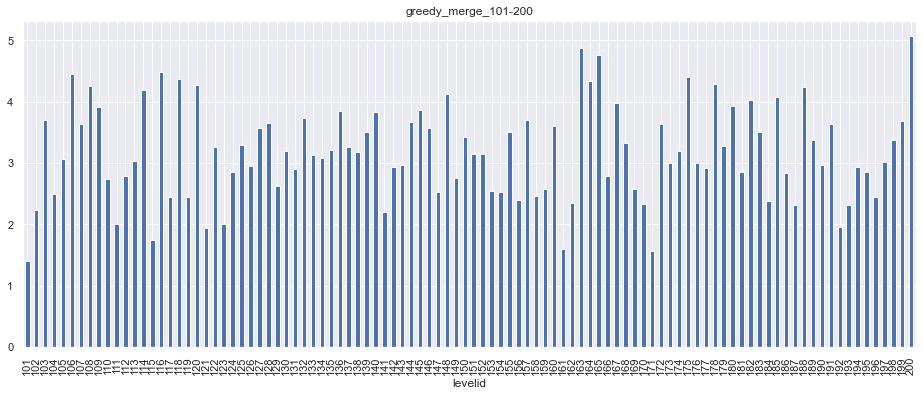

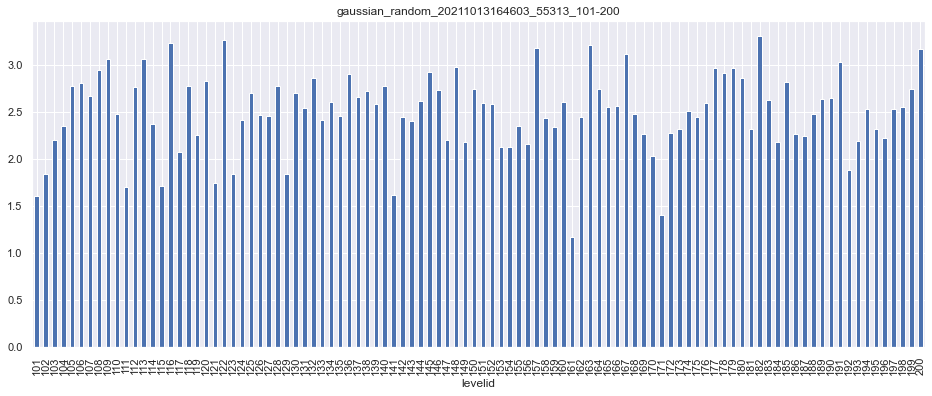

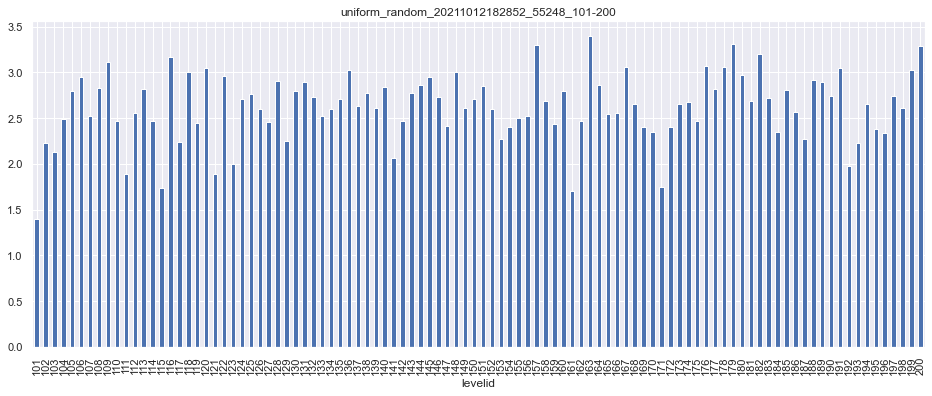

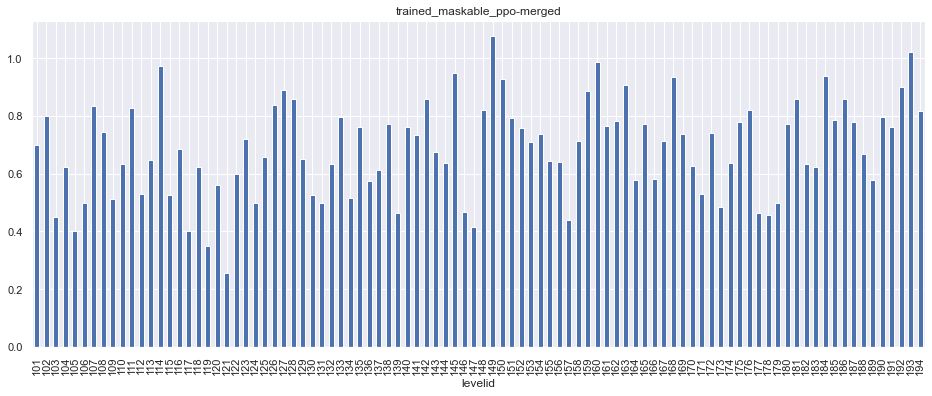

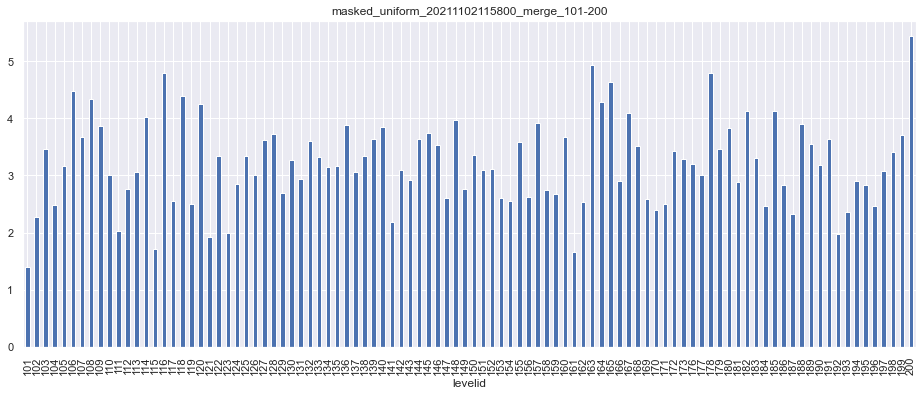

In [127]:
for ev in eval_data:
    ev['dataframe']['relative_moves_performed'] = ev['dataframe']['moves_performed'] / ev['dataframe']['move_limit']
    completed_runs = ev['dataframe'][ev['dataframe'].completed == True]
    completed_runs_stats = completed_runs.groupby("levelid").aggregate('median')
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])
    completed_runs_stats['relative_moves_performed'].plot.bar()

## Moves distribution for level 101

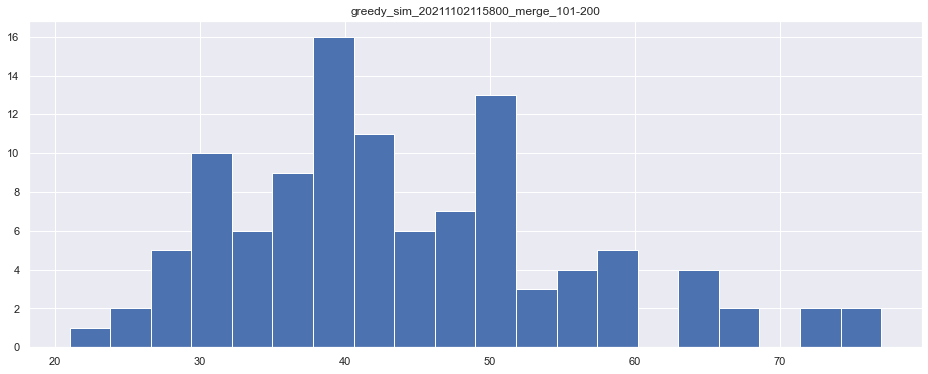

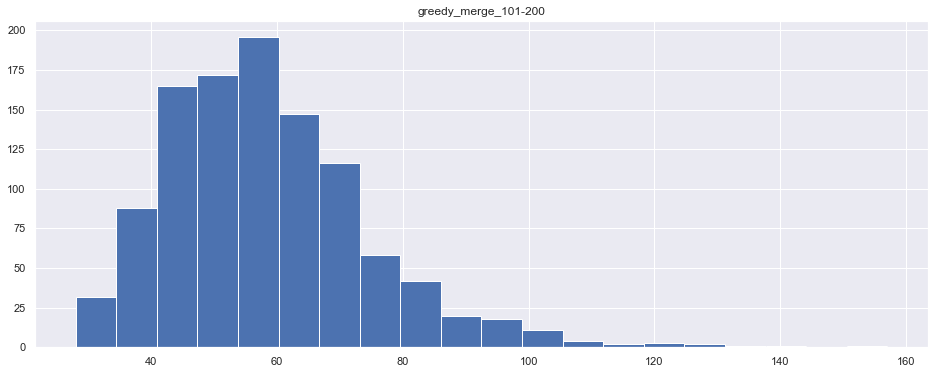

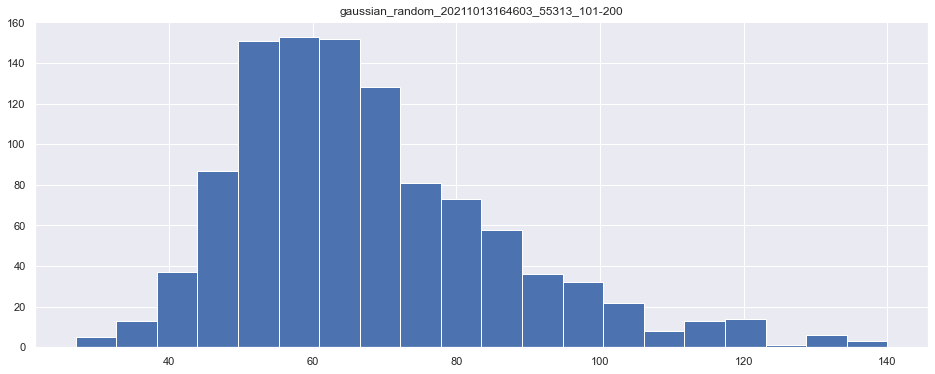

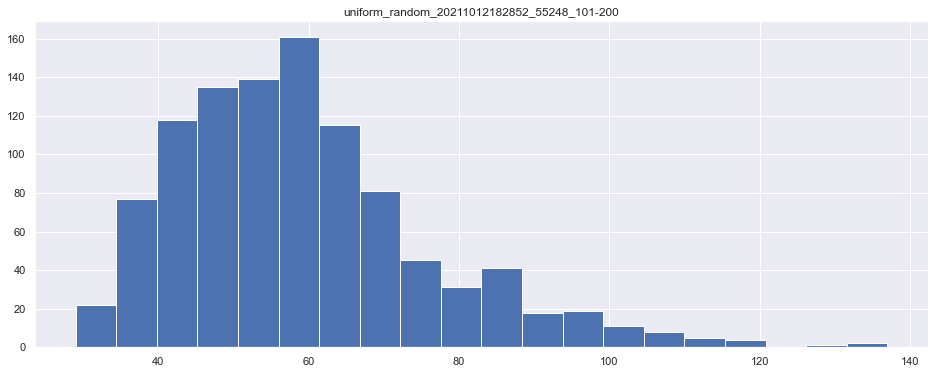

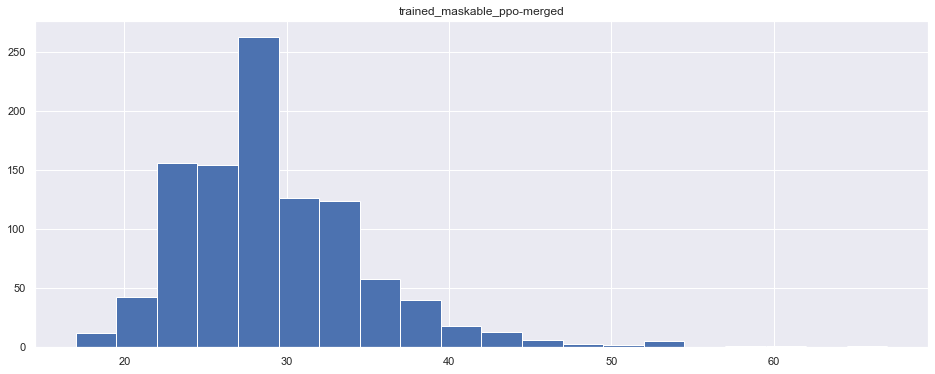

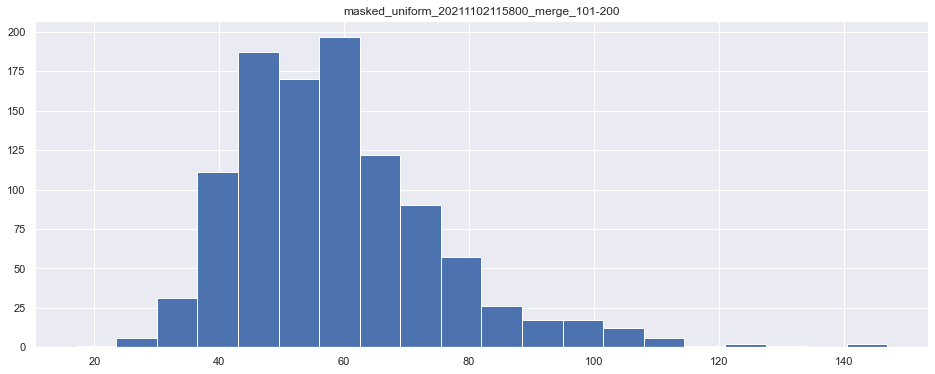

In [128]:
for ev in eval_data:
    completed_runs = ev['dataframe'][ev['dataframe'].completed == True]
    completed_runs_level = completed_runs[completed_runs['levelid'] == 101]
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])
    completed_runs_level['moves_performed'].hist(bins=20)

## Moves distribution for level 150

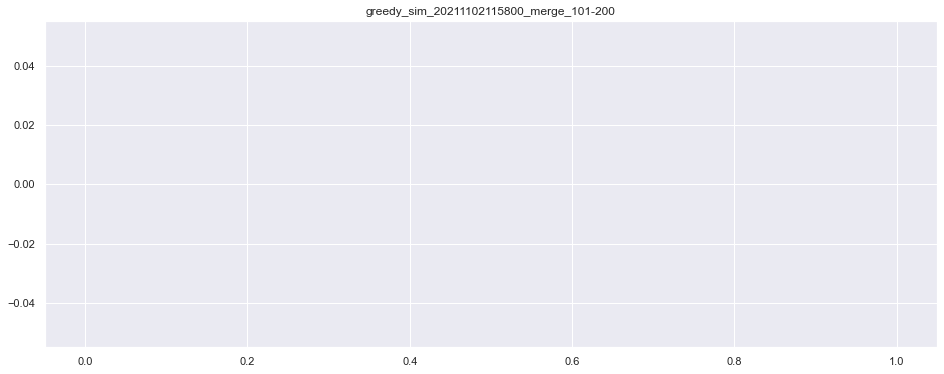

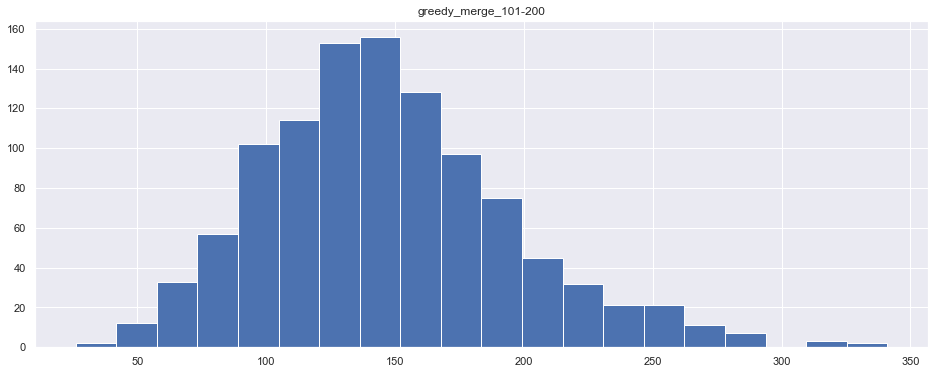

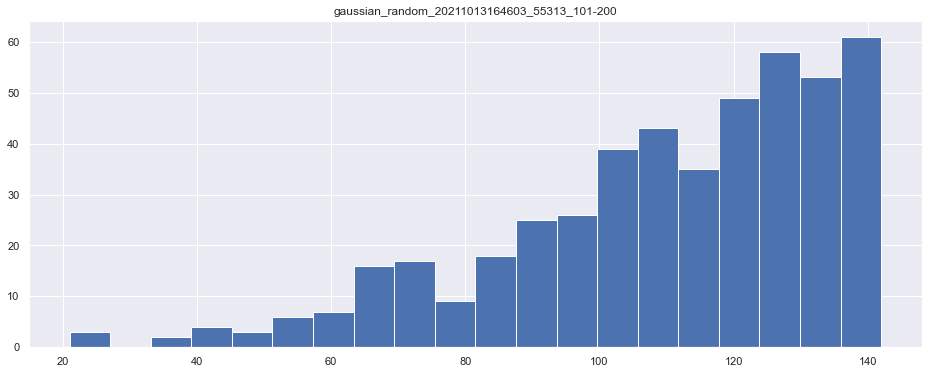

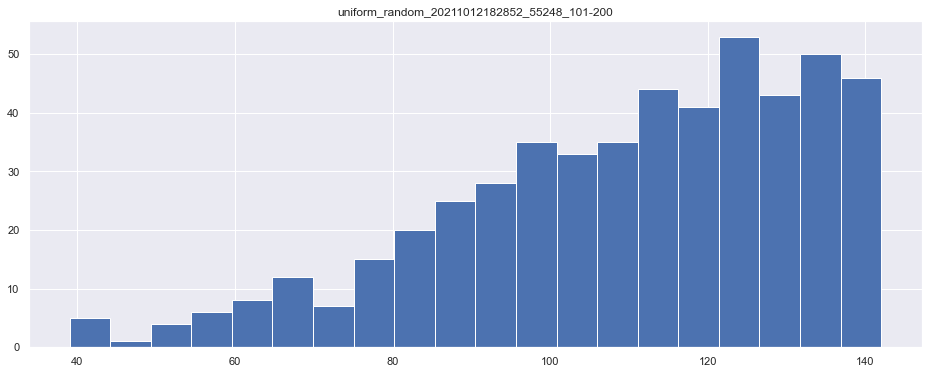

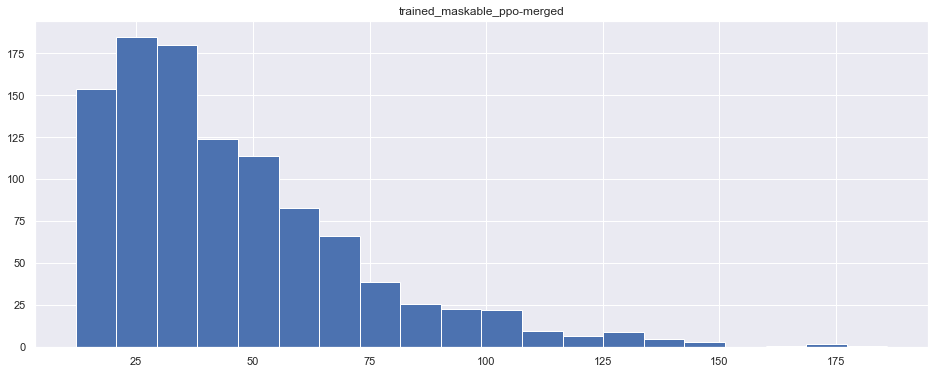

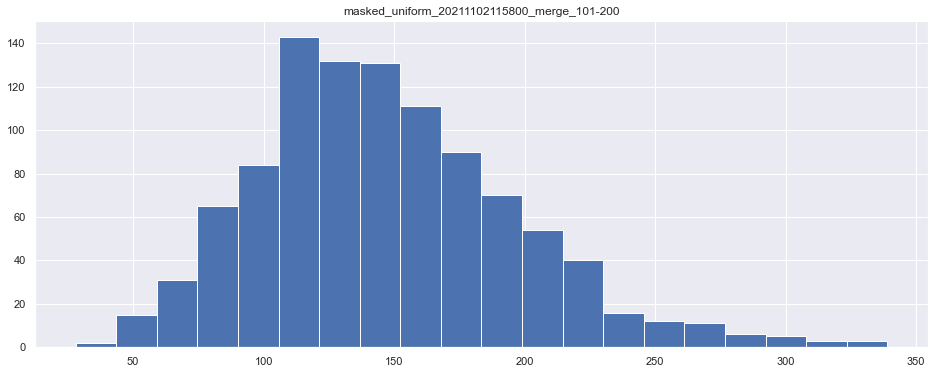

In [129]:
for ev in eval_data:
    completed_runs = ev['dataframe'][ev['dataframe'].completed == True]
    completed_runs_level = completed_runs[completed_runs['levelid'] == 150]
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])
    completed_runs_level['moves_performed'].hist(bins=20)

## Simulated move limit effect on completion rate for level 150

<BarContainer object of 40 artists>

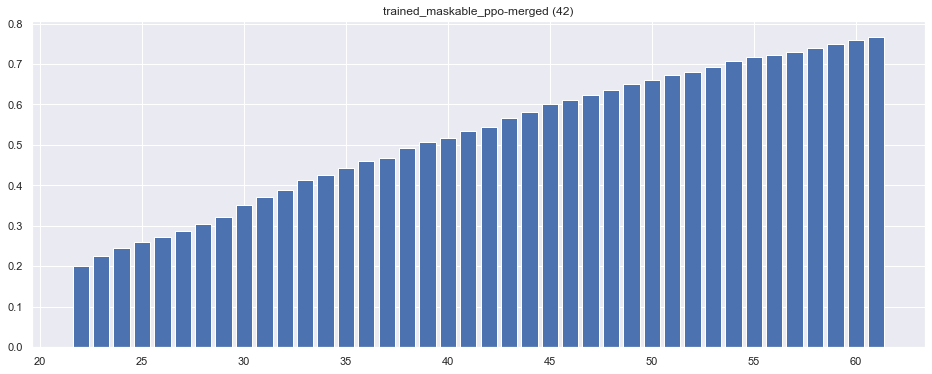

In [130]:
ev = list(filter(lambda a: a['name'] == 'trained_maskable_ppo-merged', eval_data))[0]
runs_level = ev['dataframe'][ev['dataframe']['levelid'] == 150]
level_move_limit = runs_level['move_limit'].min()

completion_rate = []
for i in range(-20,20):
    simulated_limit = level_move_limit+i
    completed = len(runs_level[runs_level['moves_performed'] <= simulated_limit])/len(runs_level['moves_performed'])
    completion_rate.append({'limit':simulated_limit,'completion':completed})

data = pandas.DataFrame(completion_rate)
plt.figure(figsize=(16, 6))
plt.title(f"{ev['name']} ({level_move_limit})")
plt.bar(data['limit'],data['completion'])
